# RL coursework, part IV (30 pts in total)

---

**Name:** Sean Craven

**SN:** 22185400

---

**Due date:** *27 March, 2023*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


$$\renewcommand{\R}{\mathbb{R}}$$
$$\newcommand{\val}{\vec{\phi}(s, a)^T \vec{w}}$$
$$\newcommand{\btwo}{\mathcal{T}^{2*}_\mathcal{Q}}$$
$$\newcommand{\Q}{\mathcal{Q}}$$
$$\renewcommand{\S}{\mathcal{S}}$$
$$\newcommand{\contract}{|\btwo q(s, a) - \btwo f(s, a)|}$$

$$\newcommand{\A}{\mathcal{A}}$$

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Q1 [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [2]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G # Believed incorrect

  # return G # Believed correct

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l * errors 
  # return errors + v

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [3]:
"""
Action = 0 is left action = 1 is right   
"""


def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  returns = np.zeros((T,))
  rho = (pi/mu)
  
  _return = 0
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    # Reversed product of decisions in time.
    _return = r[t] + d[t]*_return
    returns[t] = _return * rho[t:].prod()
  return returns 


def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = 1
  v = np.array([v_fn(o) for o in observations])
  returns = np.zeros((T,))
    
  _return = 0.
  rho = (pi/mu)
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    # Reversed product of decisions in time.
    _return = rho[t] * (r[t] + d[t]*_return)
    returns[t] = _return
  return returns 

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  rho = (pi/mu)
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    # Reversed product of decisions in time.
    if t != T-1:
      error = rho[t] * (r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error )
    else:
      error = rho[t] * (r[t] + d[t]*v[t + 1] - v[t])
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))

  error = 0.
  rho = (pi/mu)
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    # Reversed product of decisions in time.
    if t != T-1:
      error = rho[t] * min(1, 1/ rho[t]) * (r[t] + d[t]*v[t + 1] - v[t] + d[t] *error)
    else:
      error = rho[t] * min(1, 1/ rho[t]) * (r[t] + d[t]*v[t + 1] - v[t])
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors 

In [4]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
    
  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
    
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2) # integer from 0 to depth
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1) # average reward for future steps 
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[ 19.407 743.403 353.768   6.4     0.784]


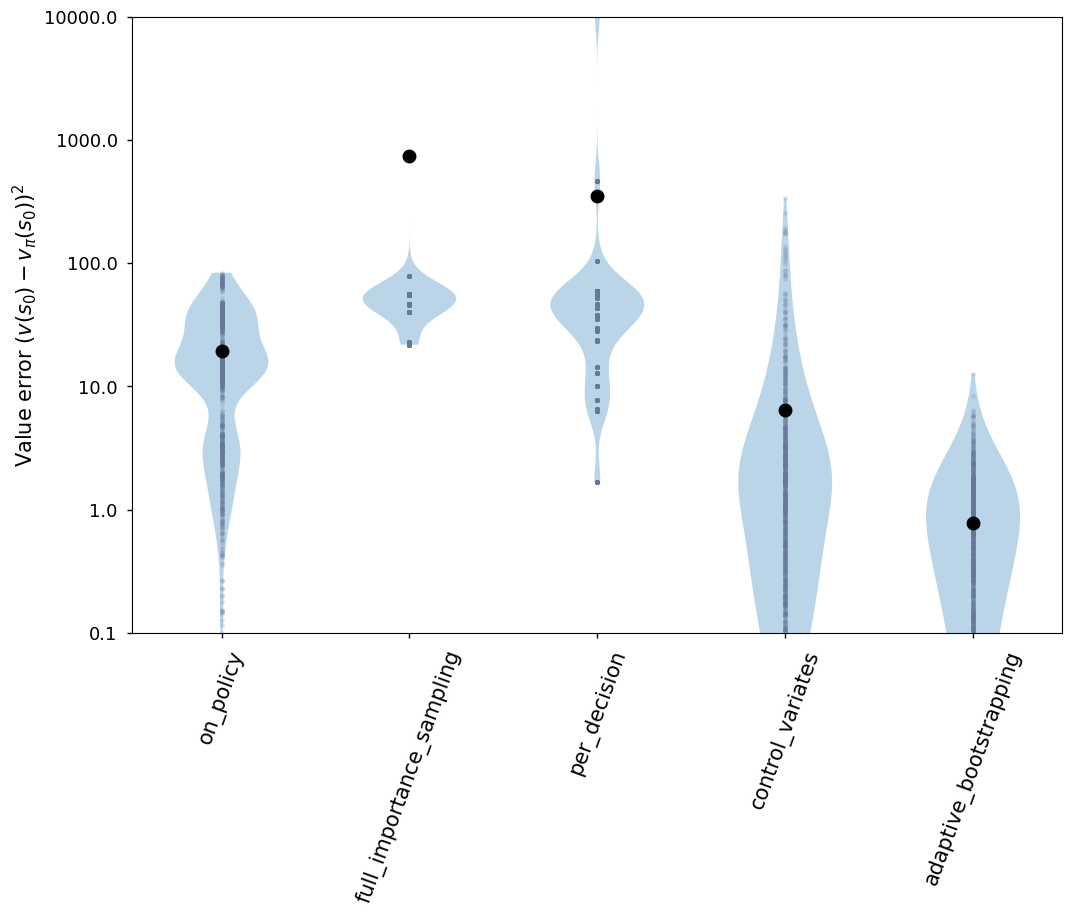

In [5]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.
 - Full-importance sampling performs the worst of all the algorithms in terms of variance. For a given return at time, $t$, the probability of taking subsequent actions doesn't affect the expected reward. However, it does affect the variance on the estimate of the expected reward. Thus for each reward, has terms which contribute to its variance, in infinite episode lengths, the variance can even be infinite. This causes it to have a high square error when we sample the value.
 - Per decision importance sampling removes the importance sampling ratio which do not contribute to the expectation, but do contribute to the variance, as such the estimate of the expectation is substantially more accurate, on average. The on-policy method ranks next, it collects its experience under the behaviour
 - The on-policy method is on policy $\mu$, rather than on policy $\pi$ for which the true value function is calculated, it also uses lambda returns(bootstrapping) as such the variance is low. However, the estimate is biased, as it estimates $v_\mu(s_0)$. 
 
 - The control variates method uses bootstrapping, on the value function, to reduce the variance of the value function estimates, and is off policy estimating $v_\pi(s_0)$. As such due to the importance weighting terms it has a higher variance than the on-policy case, however, it is estimating the value we are interested in and thus is more accurate.

 - Adaptive bootstrapping augments the control variate off-policy method to make sure that when an action is very off-policy, the lambda return is not heavily weighted by this term, this reduces the variance considerably and is estimating the correct value function of $v_\pi(s_0)$.



### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

- Yes due to biased introduced from bootstrapping. In the lowest variance methods, control variates and adaptive bootstrapping, we are using bootstrapping this can lead to bias in the value of the value function depending on how the form of the function approximation of $v$. If the function approximation of $v$ has an error associated with it then the bootstrapped values are always going to converge on a biased estimate of $v*$. Thus if there is lots of data then per decision importance sampling may produce a better estimate as it has no bootstrapping involved, given unbiased observation samples.
Finally, there may be an occurrence of the deadly triad, with the bootstrapping methods. Where you are not able to optimize the 

## Q2 [19 points total]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

i)
I adapt the proof from Convergence of Q-Learning: A simple proof F.Melo.
Assuming a finite MDP with a step coefficient where $\sum_{t=0}^{\infty} \alpha_t = \infty$ and $\sum_{t=0}^\infty \alpha_t^2 < \infty$ holds, and that all state-action pairs are visited infinitely often with an update rule,
$$
q_{t+1}(s_t, a_t) = q_{t}(s_t, a_t) + \alpha_t(s_t, a_t) \left[ r_t + \gamma r_{t+1} + \gamma^2 \max_b q_t(s_{t+2}, b) - q_t(s_t, a_t) \right].
$$
Where $\alpha_t(s_t, a_t) = 0, \forall S \neq s_t, A \neq a_t$. I define 
$$
\Delta_t(s, a) = q_t(s, a) - q^*(s, a),
$$
with $q^*$ being the fixed point of $\btwo$, taking $q^*$ away from both sides, gives;
$$
\Delta_{t+1}(s_t, a_t) = (1 - \alpha_t (s_t, a_t))\Delta_t(s_t, a_t) + \alpha_t (s_t, a_t) [ r_{t + 1} + \gamma r_{t+2} +  \gamma^2 \max_b q_t(s_{t+2}, b) - q^*(s_t, a_t) ]
$$
With $S'' = X(X(s,a), A(X(s,a)))$
$$
F_t(s, a) = r(a, s) + \gamma r( X(s, a), A(X(s, a))) + \gamma^2 \max_b q_t(S'', b) - q^*(s, a) 
$$
Where $A(s), X(s, a)$ are random  actions, states obtained from the markov chain defined by the M. 
$$
\Delta_{t+1}(s,a)  = \Delta_t(s,a)(1 -  \alpha_t(s,a)) + \alpha_t(s, a) F_t(s, a) 
$$
We can exploit Jakkola, Jordan & Singh (1993), where the equation above defines a stochastic iterative process. This stochastic process, where $ \alpha_t \phi, \Delta_t, F_t : \S \times \A -> \R^{|\A| \times |\S|}$. Additionally, given in this case that the state action space is finite as it is tabular and the Robbins-Munroe conditions, for this process to converge to zero, we must only show that;
$$
||\mathbb{E}[F_t|\mathcal{F}_t]||_\infty \leq \gamma ||\Delta_t||_\infty, \text{ with } \gamma < 1, 
$$
$$
\mathrm{Var}[F_t|\mathcal{F}_t] \leq C(1+||\Delta_t||_\infty^2), \text{ for } C > 0. 
$$
Where $\mathcal{F}_t = \{X_t, X_{t-1},....., F_{t-1}, ....., \alpha_t, ......\}$. 
First, 
$$
||\mathbb{E}[F_t|\mathcal{F}_t||_\infty = \sum_{s', s' a'} \left[ r(s, a) + \gamma   p(s'| a_t, s_t) \mu (a'| s') \{r(a', s') + \gamma p(s''|s', a') \max_{a^* \in \mathcal{A}} q(s'', a^*) \} - q^*(s, a)\right],
$$
Find the proof that $\btwo$ is a contraction operator below. Using the contraction property;
$$
 = \btwo q_t(s, a) - q^*(s, a), 
$$
$$
 = \btwo q_t(s, a) -\btwo q^*(s, a),
$$
Thus,
$$
||\mathbb{E}[F_t|\mathcal{F}_t||_\infty \leq || \btwo q_t -  \btwo q^*||_\infty \leq \gamma^2 ||q_t - q^*||_\infty.
$$
To prove finite variance,
$$
\mathrm{Var}[F_t|\mathcal{F}_t] = \mathbb{E} \left[ (r(a, s) + \gamma r(X(s, a), A(X(s,a))) + \gamma^2 \max_b q_t(S'', b) - q^*(s, a) 
 - \btwo q_t(s, a) + q^*(s, a))^2 \right],
$$
$$
 = \mathbb{E} \left[ (r(a, s) + \gamma r(X(s, a), A(X(s,a))) + \gamma^2 \max_b q_t(S'', b)  
 - \btwo q_t(s, a) )^2\right],
$$
$$
= \mathrm{Var} \left[ r(a, s) + \gamma r(X(s, a), A(X(s,a))) + \gamma^2 \max_b q_t(S'', b) | \mathcal{F_t} \right]
$$
Because the variance of the rewards of an MDP are bounded and the variance depends only linearly in $q_t$ then it is bounded. As such the two step Q learning algorithm converges to $q^*$. In the case where the rewards are a random variable only slight changes be made, such that $r(s,a) = \mathbb{E}[R|s,a]$, but the reward's variance must be finite. 

i) This convergence is only guaranteed where there are an infinite number of interactions with $M$ and all state-action pairs are visited infinitely. This would be the case under an $\epsilon$-greedy policy, for example. 

ii) If the behaviour collected from the MDP, did not visit all states-action pairs, then this algorithm wouldn't converge. 

### Contraction Operator proof:
First we define a two step contraction operator $\btwo: \Q \rightarrow \Q$;
$$
\btwo f (s, a) = r(s, a) + \gamma \sum_{s', a'}  p(s'| a_t, s_t) \mu (a'| s') \left [r(a', s') + \gamma \sum_{s''} p(s''|s', a') \max_{a^* \in \mathcal{A}} q(s'', a^*) \right] 
$$
To show that it is a $\gamma^2$ contraction with respect to $||.||_\infty$;
$$
|\btwo q(s, a) - \btwo f(s, a)| = \left|\gamma^2 \sum_{s', a'}p(s'| a_t, s_t) \mu (a'| s')\left [ \sum_{s''} p(s''|s', a') \max_{a^* \in \mathcal{A}} q(s'', a^*) - \max_{b^* \in \mathcal{A}} f(s'', b^*) \right ] \right|
$$
As $|\max_a f(a) - \max_b g(b)| \leq \max_a|f(a) - g(a)|$
$$
\contract \leq  \max_{a*} \left|\gamma^2 \sum_{s', a'}p(s'| a_t, s_t) \mu (a'| s')\left [ \sum_{s''} p(s''|s', a') \{ q(s'', a^*) -  f(s'', a^*) \} \right ]\right|

$$
Because the max over states $s''$ is greater than the expectation over the expected states, we can replace the expectation with a max
$$
\contract \leq  \max_{a^*, s^*} \left|\gamma^2 \{ q(s^*, a^*) -  f(s^*, a^*) \}\right|
$$

$$
\contract \leq \gamma^2|| q(s, a) - f(s, a)||_\infty
$$

Thus 
$$
|\contract|_\infty \leq \gamma^2|| q(s, a) - f(s, a)||_\infty \forall q, f \in \Q. 
$$
As this is a contraction mapping it has a fixed point. which we denote as $\btwo q^* = q^*$. This fixed point is by definition the same fixed point as that obtained by the bellman optimality operator, as they both find the state action value of an optimal greedy policy. 

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q5.1? (3 points). 
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

i) For case a) The greedy policy will not visit all state-action pairs infinitely many times. The updates will converge, however, they are not guaranteed to converge to the optimal policy. There, will however be a subset of state action pairs that the greedy policy will visit infinitely many times. 

As such it will converge, following the above proof, in this sub-MDP. 
For case b) The update rule becomes;
$$
\delta_t = r(S_t, A_t) + \gamma \frac{\delta(A_{t+1} = a*)}{|A|}\left[r(S_{t+1}, a^*) + \gamma q(S_{t+2}, b^*) \right] - q(s_t, a_t)
$$

$$
\delta_t(s, a) = r(s,a)  + \gamma \frac{\delta(A_{t+1} = a*)}{|A|}v_k(S_{t+1}) - q(s, a) 
$$
ii) The variance of the greedy update is the minimum possible variance, for any update step, As all transitions become deterministic.  

iii) For the greedy on policy case: In the limit of infinite interactions with the MDP, the possible states/actions are deterministic or equivalently random between equally valued states, as such with deterministic rewards, the variance can be seen to be zero for the quantity $\delta_t$;
$$
\mathrm{\delta_t} = \mathrm{Var} \left[ r_{t+1} + \gamma r_{t+2} + \gamma^2 \max_b q_t(s_{t+2}, b)\right] = 0 
$$

$$
q(s, a) = \mathbb{E}_\pi \left[\sum_{k=t}^\infty \gamma^{k-1} R_{t + k} | S_t = s, A_t = a \right]
$$
Here $\pi$ is not greedy